In [249]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys, re, datetime
from pathlib import Path
from collections import defaultdict

pj_dir = Path(os.getcwd()).parent
data_dir = pj_dir/'data'
src_dir = pj_dir/'src'
img_dir = pj_dir/'images'
sys.path.append(str(src_dir))

from matplotlib import pyplot as plt
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats 

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
df = pd.read_csv(data_dir/'talklist3.csv')

### additional_infoに「キャンセルが入っていないものだけ抽出」

In [268]:
df = df[df['additional_info'].isnull()]

In [371]:
df.shape

(57, 16)

### audience_levelを{"All": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3}で変換

In [269]:
df['level'] = df['audience_level'].replace({"All": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3})

# 割当アルゴリズム

In [348]:
def assign(df, df_assign):
    df_assign_lang = df_assign.copy()
    df_assign_genre = df_assign.copy()
    assigned_ids = []
    row_genre_dic = defaultdict(list)
    row_lang_dic = defaultdict(list)
    n_row, n_col = df_assign.shape
    for c in range(n_col):
        for r in range(n_row):
            if df_assign.iloc[r, c] == -1:
                print('割当できない時間帯です')
                continue

            target_index = 0
            force_level = 0
            while True:
                df_rest = df.query('id not in @assigned_ids')
                if df_rest.shape[0] == 0:
                    print('割当てるトークがありません')
                    df_assign.iloc[r, c] = -1
                    break
                try:
                    target_s = df_rest.iloc[target_index]
                except IndexError:
                    target_index = 0
                    force_level += 1
                    print('割当できなかったのでforce_levelを上げます', force_level)

                target_id = target_s['id']
                target_genre = target_s['genre']
                target_lang = target_s['lang']

                cond1 = target_genre in row_genre_dic[r]
                cond2 = (row_lang_dic[r].count("ja") >= 2) & (target_lang == "ja")
                cond3 = (row_lang_dic[r].count("en") >= 1) & (target_lang == "en")
                cond4 = (row_lang_dic[r].count("en") >= 2) & (target_lang == "en")

                if (force_level == 0) and (cond1 or cond2 or cond3) :
                    target_index += 1
                    continue
                
                if (force_level == 1) and (cond1 or cond4):
                    target_index += 1
                    continue

                if (force_level == 2) and (cond4):
                    target_index += 1
                    continue

                assigned_ids.append(target_id)
                row_genre_dic[r].append(target_genre)
                row_lang_dic[r].append(target_lang)
                desc = describe(target_s)
                df_assign.iloc[r, c] = desc
                df_assign_lang.iloc[r, c] = target_lang
                df_assign_genre.iloc[r, c] = target_genre
                print(f"割り当てました force_level:{force_level}", desc)
                break
    
    df_rest = df.query('id not in @assigned_ids')
    if df_rest.shape[0] > 0:
        print("割当てられていないトークがあります")
        for i, r in df.iterrows():
            print(describe(r))
    df_assign_lang = df_assign_lang.replace({0: -1})
    df_assign_genre = df_assign_genre.replace({0: -1})
        
        
    return df, df_assign, df_assign_lang, df_assign_genre

# ユーティリティ

In [271]:
def describe(s):
    title = s['title']
    id_ = s['id']
    speaker = s['name']
    genre = int(s['genre'])
    level = int(s['level'])
    lang = s['lang']
    
    desc = "{}:G{}_L{}_{}_{}__{}".format(id_, genre, level, lang, speaker, title)
    return desc

# 45分枠

In [272]:
df45 = df.query('talk_format == "Talk (45 minutes)"').copy()

### ソート

In [273]:
df45.sort_values(['priority', 'level', 'rating'], ascending=[False, True, False], inplace=True)

### 枠を準備

In [366]:
df_assign45 = pd.DataFrame(np.zeros((4, 8)))
df_assign45.iloc[0:2, 2] = -1
df_assign45.iloc[0:3, 3] = -1
df_assign45.iloc[2:4, 0] = -1

In [367]:
df_assign45

,0,1,2,3,4,5,6,7
0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0
2,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [368]:
df45, df_assign45, df_assign_lang45, df_assign_genre45 = assign(df45, df_assign45)

割り当てました force_level:0 27:G1_L1_ja_Takayuki Shimizukawa__Webアプリケーションの仕組み
割り当てました force_level:0 12:G7_L1_ja_Atsushi Odagiri__あなたと私いますぐパッケージン
割当できない時間帯です
割当できない時間帯です
割り当てました force_level:0 29:G3_L0_en_Luka Sterbic__Why you should care about types: Python Typing in the Facebook Backend
割り当てました force_level:0 28:G3_L0_ja_Yukio Okuda__オンザフライ高速化パッケージの比較：Numba, TensorFlow, Dask, etc
割り当てました force_level:0 26:G3_L0_ja_Yasushi Masuda__Migrating from Py2 application to Py3: first trial in MonotaRO / Python2 から Python3 への移植: MonotaRO での取り組み
割り当てました force_level:0 25:G7_L0_ja_Takeshi KOMIYA__Sphinx-2.0 とドキュメントの未来
割当できない時間帯です
割当できない時間帯です
割り当てました force_level:0 24:G0_L0_ja_大元 司__niconicoにおけるコンテンツレコメンドの取り組み
割り当てました force_level:0 21:G5_L0_ja_Yasuaki Matsuda__Djangoアプリケーションにおけるトイル撲滅戦記
割当できない時間帯です
割当できない時間帯です
割当できない時間帯です
割り当てました force_level:0 4:G0_L0_en_Kajal Puri__Build text classification models ( CBOW and Skip-gram) with FastText in python
割り当てました force_level:0 22:G7_L0_ja_Daisuke Saito__PyCon JP における子ども向け

In [369]:
df_assign45

,0,1,2,3,4,5,6,7
0,27:G1_L1_ja_Takayuki Shimizukawa__Webアプリケーションの仕組み,29:G3_L0_en_Luka Sterbic__Why you should care ...,-1,-1,22:G7_L0_ja_Daisuke Saito__PyCon JP における子ども向けワ...,10:G0_L3_ja_NUKUI Shun__実践・競馬データサイエンス,18:G2_L2_en_Denys Makogon__Applying serverless...,13:G5_L0_ja_かしゅー__DjangoではじめるPyCharm実践入門
1,12:G7_L1_ja_Atsushi Odagiri__あなたと私いますぐパッケージン,28:G3_L0_ja_Yukio Okuda__オンザフライ高速化パッケージの比較：Num...,-1,-1,8:G0_L0_en_sandeep saurabh__Probabilistic Prog...,60:G1_L2_en_nan__Building Maintainable Python ...,20:G5_L2_ja_Masashi SHIBATA__Django REST Frame...,9:G7_L0_ja_Yuta KItagami__Pythonを使ったハードウェア開発について
2,-1,26:G3_L0_ja_Yasushi Masuda__Migrating from Py2...,24:G0_L0_ja_大元 司__niconicoにおけるコンテンツレコメンドの取り組み,-1,11:G7_L1_en_MoonWalker__HomeSecurity with Python,15:G5_L2_ja_Takahiro Ethan Ikeuchi__Integrate ...,23:G0_L2_ja_Hayao Suzuki__SymPyによる数式処理,14:G2_L0_ja_Atsushi Fukui__「リモートペアプロでマントルを突き抜け...
3,-1,25:G7_L0_ja_Takeshi KOMIYA__Sphinx-2.0 とドキュメントの未来,21:G5_L0_ja_Yasuaki Matsuda__Djangoアプリケーションにおけ...,4:G0_L0_en_Kajal Puri__Build text classificati...,19:G2_L1_ja_Keisuke Nishitani__Pythonistaに贈るコン...,16:G3_L2_ja_yotchang4s (Yoshiaki Shibutani)__J...,17:G5_L1_ja_denzow__Djangoだってカンバンつくれるもん(Django...,-1


In [380]:
df.shape

(57, 16)

In [376]:
df_assign30.size + df_assign45.size

72

In [379]:
(df_assign30 != -1).sum().sum() 

33

In [374]:
(df_assign30 != -1).sum().sum() + (df_assign45 != -1).sum().sum()

57

In [370]:
df_assign45.to_clipboard(sep=';', index=False)

In [354]:
title_dict45 = ['Day1 No1', 'Day1 No2', 'Day2 No1',  'Day2 No2']

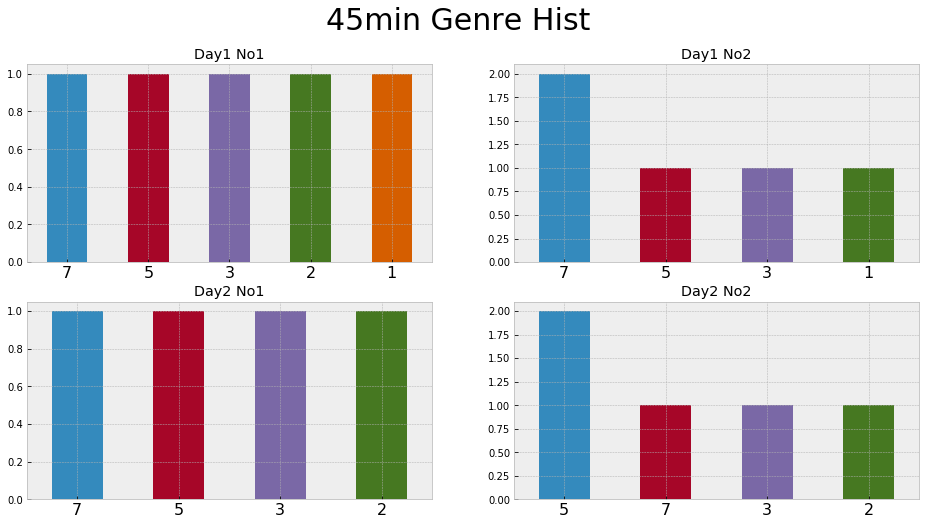

In [355]:
fig = plt.figure(figsize=(16, 8))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    tmp_s = df_assign_genre45.T[i].astype(int).value_counts()
    tmp_s = tmp_s[tmp_s.index != -1]
    tmp_s.plot(kind='bar', ax=ax)
    ax.set_title(title_dict45[i])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16 ) 
fig.suptitle('45min Genre Hist', fontsize=30)
plt.savefig(img_dir/'45genre.png', bbox_inches='tight', pad_inches=0)

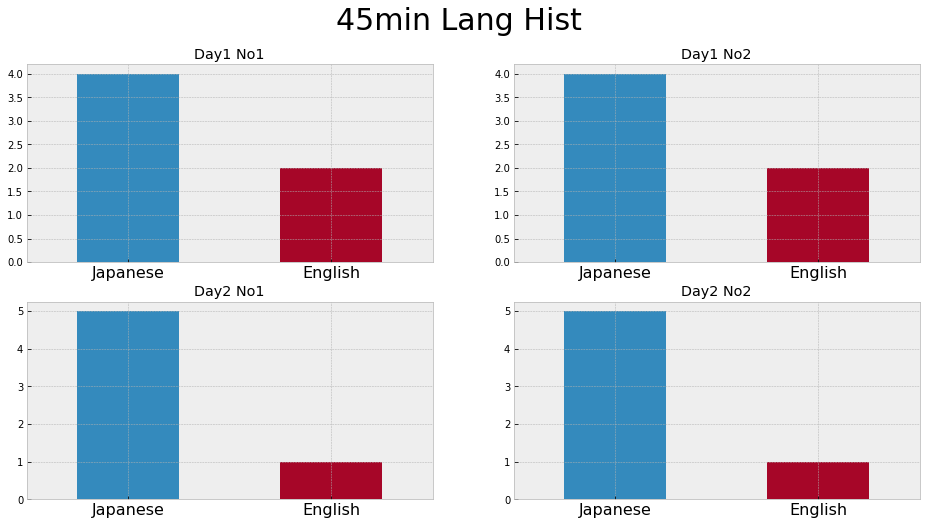

In [356]:
fig = plt.figure(figsize=(16, 8))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    tmp_s = df_assign_lang45.T[i].replace({'en': 'English', 'ja': 'Japanese'}).value_counts()
    tmp_s = tmp_s[tmp_s.index != -1]
    tmp_s.plot(kind='bar', ax=ax)
    ax.set_title(title_dict45[i])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16 ) 
fig.suptitle('45min Lang Hist', fontsize=30)
plt.savefig(img_dir/'45lang.png', bbox_inches='tight', pad_inches=0)

# 30分枠

In [322]:
df30 = df.query('talk_format == "Talk (30 minutes)"').copy()
df30.sort_values(['priority', 'level', 'rating'], ascending=[False, True, False], inplace=True)

### 枠を準備

In [357]:
df_assign30 = pd.DataFrame(np.zeros((5, 8)))
df_assign30.iloc[0:2, 2] = -1
df_assign30.iloc[:, 3] = -1

In [358]:
df_assign30

,0,1,2,3,4,5,6,7
0,0.0,0.0,-1.0,-1,0.0,0.0,0.0,0.0
1,0.0,0.0,-1.0,-1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0


In [359]:
df30, df_assign30, df_assign_lang30, df_assign_genre30 = assign(df30, df_assign30)

割り当てました force_level:0 49:G7_L0_en_Misha Penkov__Fun with Python and Kanji
割り当てました force_level:0 5:G0_L0_en_Dror Ayalon__Creative Music Applications in Python
割り当てました force_level:0 41:G7_L0_ja_Lina KATAYOSE(selina)__Make a Drone using RaspberryPi and Google VoiceKit by Python
割り当てました force_level:0 57:G0_L0_ja_NIIKURA Ryota__1次元畳み込みフィルターを利用した音楽データのオートエンコーダ
割り当てました force_level:0 37:G0_L0_en_Parul Sethi__Visualizing Topic Models
割り当てました force_level:0 36:G4_L0_ja_driller__Jupyterで広がるPythonの可能性
割り当てました force_level:0 34:G6_L0_ja_Masataka Arai__Pythonで解く大学入試数学
割り当てました force_level:0 52:G0_L0_en_Alizishaan Khatri__Detecting offensive messages using Deep Learning: A micro-service based approach
割り当てました force_level:0 56:G5_L0_en_Mehul Patel__Adding JWT Authentication to Python and Django REST Framework Using Auth0
割り当てました force_level:0 7:G1_L0_ja_Shintaro Tanaka__Pythonで始めるウェブスクレイピング実践入門
割当できない時間帯です
割当できない時間帯です
割り当てました force_level:0 44:G3_L1_ja_tell-k__Pythonでざっくり学ぶUnixプロセス
割り当てました force_level:0 3

In [360]:
df_assign30

,0,1,2,3,4,5,6,7
0,49:G7_L0_en_Misha Penkov__Fun with Python and ...,36:G4_L0_ja_driller__Jupyterで広がるPythonの可能性,-1,-1,55:G0_L0_ja_Ryusuke Chiba__メルカリにおける AI 活用事例,59:G3_L1_ja_nan__初心者が読み解くvenvのナカミ,39:G1_L2_en_Hsiaoming Yang__The Modern OAuth 2.0,47:G0_L1_ja_Tomoko FURUKI__Interactive Network...
1,5:G0_L0_en_Dror Ayalon__Creative Music Applica...,34:G6_L0_ja_Masataka Arai__Pythonで解く大学入試数学,-1,-1,6:G1_L1_ja_Takeshi Sugiyama__自分が欲しいものをPythonで書...,43:G7_L2_ja_Doni Rubiagatra__Pythonistaの選球眼（せん...,58:G3_L2_ja_nan__Rust と Python,"48:G0_L2_en_Hikaru Matsuoka , Ph.D.__How to Da..."
2,41:G7_L0_ja_Lina KATAYOSE(selina)__Make a Dron...,52:G0_L0_en_Alizishaan Khatri__Detecting offen...,44:G3_L1_ja_tell-k__Pythonでざっくり学ぶUnixプロセス,-1,35:G4_L1_en_Kazuki Yokoishi__Notebook as Web A...,42:G2_L2_ja_Masaki Yatsu__複数アプリケーションのプロセスとログを管...,61:G0_L2_ja_nan__契約書データ関連のAI開発に伴う、前処理及び匿名化処理につ...,38:G7_L2_ja_あべんべん__WILDCAT SDKは量子コンピュータビジネスの味方...
3,57:G0_L0_ja_NIIKURA Ryota__1次元畳み込みフィルターを利用した音楽...,56:G5_L0_en_Mehul Patel__Adding JWT Authentica...,31:G7_L0_ja_Yusuke Nishio__Python研修の作り方-Teachi...,-1,53:G3_L3_ja_Takumi Sueda__C拡張と共に乗り切るPython 2→3移行術,50:G1_L2_en_Iskandar Setiadi__From Data to Web...,32:G7_L2_ja_takumi.ohyama@ariseanalytics.com__...,45:G0_L1_en_David__Interpretable Machine Learn...
4,37:G0_L0_en_Parul Sethi__Visualizing Topic Models,7:G1_L0_ja_Shintaro Tanaka__Pythonで始めるウェブスクレイピ...,40:G6_L1_ja_小栗 潤一__Pythonで「お絵描きパズル」を解いてみた。,-1,54:G7_L1_ja_nan__AltJSとしてのPython - フロントエンドをPyt...,51:G5_L2_ja_向山 裕介 (Yusuke Mukoyama)__Django を ...,33:G0_L2_ja_yuya.morinaga@vuzz.com__料理写真が美味しく撮...,"30:G2_L0_en_Pavlos Christoforou__Python, AWS a..."


In [365]:
df_assign30.to_clipboard(sep=';', index=False)

In [362]:
title_dict30 = ['Day1 No1', 'Day1 No2', 'Day2 No1', 'Day2 No2', 'Day2 No3']

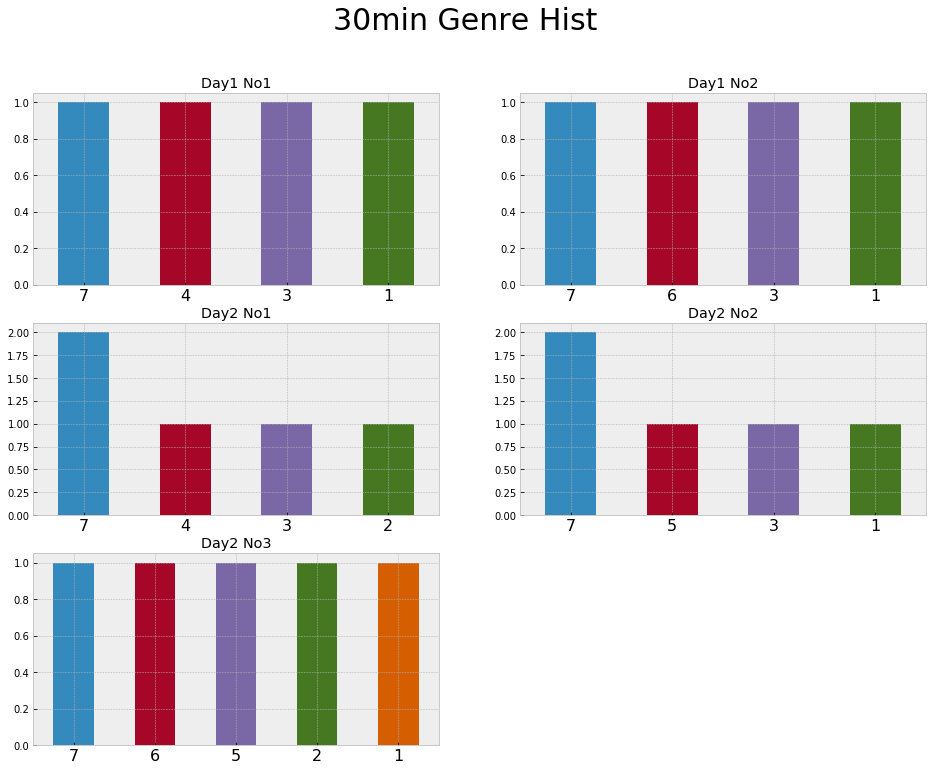

In [363]:
fig = plt.figure(figsize=(16, 12))
for i in range(5):
    ax = fig.add_subplot(3, 2, i+1)
    tmp_s = df_assign_genre30.T[i].astype(int).value_counts()
    tmp_s = tmp_s[tmp_s.index != -1]
    tmp_s.plot(kind='bar', ax=ax)
    ax.set_title(title_dict30[i])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16 ) 
fig.suptitle('30min Genre Hist', fontsize=30 )
plt.savefig(img_dir/'30genre.png', bbox_inches='tight', pad_inches=0)

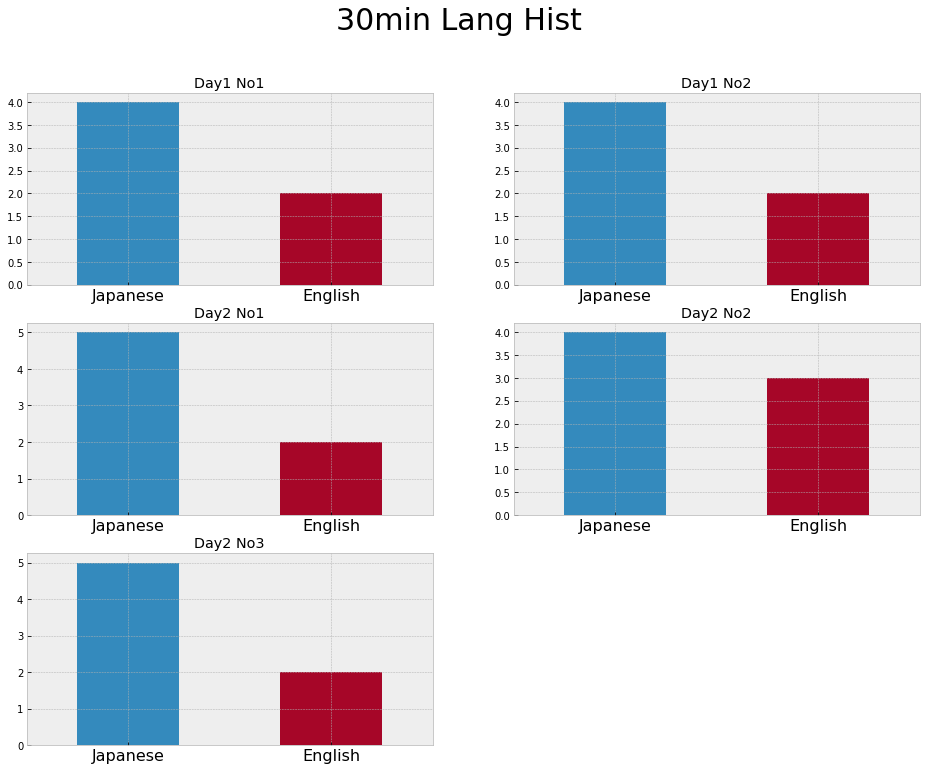

In [364]:
fig = plt.figure(figsize=(16, 12))
for i in range(5):
    ax = fig.add_subplot(3, 2, i+1)
    tmp_s = df_assign_lang30.T[i].replace({'en': 'English', 'ja': 'Japanese'}).value_counts()
    tmp_s = tmp_s[tmp_s.index != -1]
    tmp_s.plot(kind='bar', ax=ax)
    ax.set_title(title_dict30[i])
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0, fontsize=16 ) 
fig.suptitle('30min Lang Hist', fontsize=30)
plt.savefig(img_dir/'30lang.png', bbox_inches='tight', pad_inches=0)